# A New Approach

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
tax_all_df= pd.read_csv("resources/Tax_DF_All_Columns_For_Merge.csv")

brewery_df= pd.read_csv("resources/Brewers_Association_Data.csv")

In [4]:
tax_all_df.head()

,Unnamed: 0,STATE FIPS,STATE,ZIPCODE,Unnamed: 4,NUMBER OF RETURNS,MARITAL STATUS (SINGLE),MARITAL STATUS (JOINT),MARITAL STATUS (HEAD OF HOUSEHOLD),RETURNS WITH SIGNATURE,...,NUMBER OF RETURNS WITH TOTAL TAX CREDITS,TOTAL TAX CREDITS AMOUNT,NUMBER OF RETURNS WITH FOREIGN TAX CREDIT,FOREIGN TAX CREDIT AMOUNT,NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT,CHILD AND DEPENDENT CARE CREDIT AMOUNT,NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX,SELF-EMPLOYMENT TAX AMOUNT,NUMBER OF RETURNS WITH INCOME TAX,INCOME TAX AMOUNT
0,1,1,AL,35004,0,5210,2150,2140,830,2470,...,1840,2377,80,7,410,245,530,1190,3870,27082
1,2,1,AL,35005,0,3100,1340,890,830,1740,...,1000,1066,0,0,180,102,250,368,1970,8580
2,3,1,AL,35006,0,1200,430,600,170,790,...,360,441,0,0,0,0,100,172,860,4712
3,4,1,AL,35007,0,11940,4770,5140,1750,5450,...,4070,5256,250,13,850,481,1710,4161,8440,70623
4,5,1,AL,35010,0,7910,2910,2730,2120,4090,...,2470,2949,200,191,490,253,860,2088,4680,38102


In [5]:
brewery_df.head()

,Unnamed: 0,Brewery,Address,City,State,ZIP Code
0,0,5 Rivers Brewing LLC,NaN,Spanish Fort,AL,36527.0
1,1,Avondale Brewing Co,201 41st St S,Birmingham,AL,35222.0
2,2,Back Forty Beer Co,200 N 6th St,Gadsden,AL,35901.0
3,3,Back Forty Beer Company - Birmingham,3201 1st Avenue N,Birmingham,AL,35222.0
4,4,Below the Radar Brewing Co,220 Holmes Ave NE,Huntsville,AL,35801.0


In [6]:
def trim_fraction(text):
    if ".0" in text:
        return text[:text.rfind(".0")]
    return text

brewery_df["Address"] = brewery_df["Address"].astype("str")
brewery_df["Brewery"] = brewery_df["Brewery"].astype("str")
brewery_df["ZIP Code"] = brewery_df["ZIP Code"].astype("str")
# brewery_df["ZIP Code"].fillna("000999", inplace= True)
# brewery_df["ZIP Code"] = brewery_df["ZIP Code"].astype("int32")

# try:
#     brewery_df["ZIP Code"] = brewery_df["ZIP Code"].astype("int32")

brewery_df["Brewery"] = brewery_df["Brewery"].str.lower()
brewery_df["Address"] = brewery_df["Address"].str.lower()

no_double_address_df = brewery_df.drop_duplicates(["Address"])
no_double_address_or_brewery_df = no_double_address_df.drop_duplicates(["Brewery"])

In [7]:
brewery_df.dtypes

Unnamed: 0     int64
Brewery       object
Address       object
City          object
State         object
ZIP Code      object
dtype: object

In [8]:
no_double_address_or_brewery_df["ZIP Code"] = no_double_address_or_brewery_df["ZIP Code"].apply(trim_fraction)

C:\Users\Overlord\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
brewery_df= no_double_address_or_brewery_df

In [10]:
brewery_df.head()

,Unnamed: 0,Brewery,Address,City,State,ZIP Code
0,0,5 rivers brewing llc,nan,Spanish Fort,AL,36527
1,1,avondale brewing co,201 41st st s,Birmingham,AL,35222
2,2,back forty beer co,200 n 6th st,Gadsden,AL,35901
3,3,back forty beer company - birmingham,3201 1st avenue n,Birmingham,AL,35222
4,4,below the radar brewing co,220 holmes ave ne,Huntsville,AL,35801


In [11]:
tax_all_df = tax_all_df.rename(columns = {
    "ZIPCODE": "ZIP Code"
})
tax_all_df["ZIP Code"] = tax_all_df["ZIP Code"].astype("str")

In [12]:
full_merge_df = pd.merge(tax_all_df, brewery_df, how = "outer",
                        on= "ZIP Code")

In [13]:
pd.set_option('display.max_columns', 500)

In [14]:
del full_merge_df["Unnamed: 4"]
full_merge_df.head()

,Unnamed: 0_x,STATE FIPS,STATE,ZIP Code,NUMBER OF RETURNS,MARITAL STATUS (SINGLE),MARITAL STATUS (JOINT),MARITAL STATUS (HEAD OF HOUSEHOLD),RETURNS WITH SIGNATURE,NUMBER OF EXEMPTIONS,NUMBER OF DEPENDENTS,ELDERLY,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT,NUMBER OF FARM RETURNS,NUMBER OF RETURNS WITH UNEMPLOYMENT COMPENSATION,UNEMPLOYMENT COMPENSATION AMOUNT,NUMBER OF RETURNS WITH SOCIAL SECURITY BENEFITS,TAXABLE SOCIAL SECURITY BENEFITS AMOUNT,NUMBER OF RETURNS WITH EDUCATION EXPENSES,EDUCATION EXPENSES AMOUNT,NUMBER OF RETURNS WITH STUDENT LOAN DEDUCTIONS,STUDENT LOAN DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH TUITION AND FEEDS DEDUCTIONS,TUITION AND FEEDS DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH DOMESTIC PRODUCTION ACTIVITIES DEDUCTIONS,DOMESTIC PRODUCTION ACTIVITES DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH REAL ESTATE TAXES,REAL ESTATE TAXES AMOUNT,NUMBER OF RETURNS WITH PERSONAL PROPERTY TAXES,PERSONAL PROPERTY TAXES AMOUNT,NUMBER OF RETURNS WITH TOTAL CHARITABLE CONTRIBUTIONS,TOTAL CHARITABLE CONTRIBUTIONS AMOUNT,NUMBER OF RETURNS WITH TAXABLE INCOME,TAXABLE INCOME AMOUNT,NUMBER OF RETURNS WITH INCOME TAX BEFORE CREDITS,INCOME TAX BEFORE CREDITS AMOUNT,NUMBER OF RETURNS WITH TOTAL TAX CREDITS,TOTAL TAX CREDITS AMOUNT,NUMBER OF RETURNS WITH FOREIGN TAX CREDIT,FOREIGN TAX CREDIT AMOUNT,NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT,CHILD AND DEPENDENT CARE CREDIT AMOUNT,NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX,SELF-EMPLOYMENT TAX AMOUNT,NUMBER OF RETURNS WITH INCOME TAX,INCOME TAX AMOUNT,Unnamed: 0_y,Brewery,Address,City,State
0,1.0,1.0,AL,35004,5210.0,2150.0,2140.0,830.0,2470.0,10510.0,3430.0,1090.0,5210.0,290260.0,4550.0,234833.0,0.0,110.0,332.0,680.0,8444.0,120.0,30.0,590.0,603.0,50.0,112.0,0.0,0.0,1410.0,1042.0,1230.0,306.0,1470.0,7777.0,4280.0,187073.0,4290.0,29498.0,1840.0,2377.0,80.0,7.0,410.0,245.0,530.0,1190.0,3870.0,27082.0,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,AL,35005,3100.0,1340.0,890.0,830.0,1740.0,6020.0,2170.0,710.0,3100.0,121690.0,2660.0,98565.0,0.0,110.0,367.0,460.0,4358.0,60.0,14.0,210.0,226.0,30.0,71.0,0.0,0.0,590.0,482.0,550.0,200.0,750.0,3842.0,2310.0,67341.0,2320.0,9649.0,1000.0,1066.0,0.0,0.0,180.0,102.0,250.0,368.0,1970.0,8580.0,NaN,NaN,NaN,NaN,NaN
2,3.0,1.0,AL,35006,1200.0,430.0,600.0,170.0,790.0,2560.0,820.0,310.0,1200.0,57418.0,1040.0,43707.0,0.0,70.0,209.0,230.0,2638.0,0.0,0.0,50.0,45.0,0.0,0.0,0.0,0.0,190.0,175.0,200.0,76.0,210.0,1090.0,920.0,34951.0,920.0,5154.0,360.0,441.0,0.0,0.0,0.0,0.0,100.0,172.0,860.0,4712.0,NaN,NaN,NaN,NaN,NaN
3,4.0,1.0,AL,35007,11940.0,4770.0,5140.0,1750.0,5450.0,24950.0,8840.0,2460.0,11940.0,697882.0,10180.0,545418.0,30.0,240.0,671.0,1610.0,22746.0,340.0,83.0,1260.0,1346.0,130.0,378.0,30.0,246.0,3460.0,4035.0,3020.0,1019.0,3550.0,19564.0,9380.0,455626.0,9380.0,75881.0,4070.0,5256.0,250.0,13.0,850.0,481.0,1710.0,4161.0,8440.0,70623.0,39.0,siluria brewing company,145 1st ave w,Alabaster,AL
4,5.0,1.0,AL,35010,7910.0,2910.0,2730.0,2120.0,4090.0,16330.0,6070.0,1850.0,7910.0,384319.0,6700.0,266658.0,90.0,290.0,596.0,1200.0,16274.0,200.0,52.0,440.0,422.0,40.0,121.0,0.0,0.0,1270.0,1789.0,1140.0,312.0,1390.0,10069.0,5570.0,231564.0,5590.0,41031.0,2470.0,2949.0,200.0,191.0,490.0,253.0,860.0,2088.0,4680.0,38102.0,NaN,NaN,NaN,NaN,NaN


In [15]:
brewery_zips_df= full_merge_df
brewery_zips_df['Brewery Count'] = full_merge_df['ZIP Code'].groupby(full_merge_df['ZIP Code']).transform('count')
brewery_zips_plural_df= brewery_zips_df.loc[brewery_zips_df['Brewery Count'] > 1]
brewery_zips_plural_no_dups_df= brewery_zips_plural_df.drop_duplicates("ZIP Code")

len(brewery_zips_plural_no_dups_df)

1491

In [16]:
#Regression building
x= full_merge_df["NUMBER OF RETURNS"]
y= full_merge_df["ELDERLY"]
x_sum= x.sum()
y_sum= y.sum()

x_bar= x_sum/len(x)
y_bar= y_sum/len(y)

x_times_y_sum= (x*y).sum()
x_times_y_mean= x_times_y_sum/len(x)

x_squareds= (x ** 2)
x_squareds_mean = (x ** 2).sum()/len(x)

In [17]:
(x ** 2).sum()

2784205604300.0

In [18]:
print(x_bar)
print(y_bar)
print((x*y).sum()/len(x))
print(x_times_y_mean)
print(x_squareds_mean)
print((x ** 2).sum()/len(x))

5626.572195613045
1295.1667225967844
18200162.112938162
18200162.112938162
84938698.68818451
84938698.68818451


In [19]:
def regression_func(x,y):

    x_sum= x.sum()
    y_sum= y.sum()

    x_bar= x_sum/len(x)
    y_bar= y_sum/len(y)

    x_times_y_sum= (x*y).sum()
    x_times_y_mean= x_times_y_sum/len(x)

    x_squareds= (x ** 2)
    x_squareds_mean = (x ** 2).sum()/len(x)

    m= ((x_bar*y_bar) - x_times_y_mean)/((x_bar ** 2) - x_squareds_mean)
    b= y_bar - m*x_bar
    
    x_min= x.min()
    x_max= x.max()
    
    return {m: m,
            b: b,
            x_min: x_min,
            x_max: x_max
           }

In [20]:
mask= ~np.isnan(full_merge_df["NUMBER OF RETURNS"]) & ~np.isnan(full_merge_df["ELDERLY"])
m,b,r,p,st_err= linregress(full_merge_df["NUMBER OF RETURNS"][mask],full_merge_df["ELDERLY"][mask])

In [24]:
print(m)
print(b)
print(r)
print(p)
print(st_err)

0.20478906536316993
143.18582742954845
0.9179795130982116
0.0
0.0004892115947180478


In [25]:
m

0.20478906536316993

In [26]:
def plot_regression(x,y,x_min,x_max):
    
    plt.scatter(full_merge_df[x],full_merge_df[y])
    plt.plot([x_min,x_max], [m*x_min+b,m*x_max+b], 'r')

    plt.title(x+" vs "+y)
    plt.xlabel(x)
    plt.ylabel(y)

#     plt.savefig("images/Number_of_Returns_vs_Elderly.png")
    plt.show()

In [27]:
test_x= pd.Series(full_merge_df["NUMBER OF RETURNS"])
test_y= pd.Series(full_merge_df["ELDERLY"])

# test_x= full_merge_df.loc[:,["NUMBER OF RETURNS","TOTAL INCOME AMOUNT"]]
# test_y= full_merge_df.loc[:,["ELDERLY","NUMBER OF RETURNS WITH TOTAL INCOME"]]

In [28]:
test_y.head()

0    1090.0
1     710.0
2     310.0
3    2460.0
4    1850.0
Name: ELDERLY, dtype: float64

In [29]:
m,b,x_max, x_min= regression_func(test_x,test_y)

In [30]:
print(m)
print(b)
print(x_min)
print(x_max)

0.20481858838833145
142.74014802628585
53900.0
40.0


# Unneccessary note:
That outlier is The Villages, FL 32162. It was the [fastest growing metropolitan area between 2010 and 2017](https://en.wikipedia.org/wiki/The_Villages,_Florida "The Villages, FL - Wikipedia").

In [31]:
elderly_max= full_merge_df.loc[full_merge_df["ELDERLY"] == full_merge_df["ELDERLY"].max()]
elderly_max

,Unnamed: 0_x,STATE FIPS,STATE,ZIP Code,NUMBER OF RETURNS,MARITAL STATUS (SINGLE),MARITAL STATUS (JOINT),MARITAL STATUS (HEAD OF HOUSEHOLD),RETURNS WITH SIGNATURE,NUMBER OF EXEMPTIONS,NUMBER OF DEPENDENTS,ELDERLY,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT,NUMBER OF FARM RETURNS,NUMBER OF RETURNS WITH UNEMPLOYMENT COMPENSATION,UNEMPLOYMENT COMPENSATION AMOUNT,NUMBER OF RETURNS WITH SOCIAL SECURITY BENEFITS,TAXABLE SOCIAL SECURITY BENEFITS AMOUNT,NUMBER OF RETURNS WITH EDUCATION EXPENSES,EDUCATION EXPENSES AMOUNT,NUMBER OF RETURNS WITH STUDENT LOAN DEDUCTIONS,STUDENT LOAN DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH TUITION AND FEEDS DEDUCTIONS,TUITION AND FEEDS DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH DOMESTIC PRODUCTION ACTIVITIES DEDUCTIONS,DOMESTIC PRODUCTION ACTIVITES DEDUCTIONS AMOUNT,NUMBER OF RETURNS WITH REAL ESTATE TAXES,REAL ESTATE TAXES AMOUNT,NUMBER OF RETURNS WITH PERSONAL PROPERTY TAXES,PERSONAL PROPERTY TAXES AMOUNT,NUMBER OF RETURNS WITH TOTAL CHARITABLE CONTRIBUTIONS,TOTAL CHARITABLE CONTRIBUTIONS AMOUNT,NUMBER OF RETURNS WITH TAXABLE INCOME,TAXABLE INCOME AMOUNT,NUMBER OF RETURNS WITH INCOME TAX BEFORE CREDITS,INCOME TAX BEFORE CREDITS AMOUNT,NUMBER OF RETURNS WITH TOTAL TAX CREDITS,TOTAL TAX CREDITS AMOUNT,NUMBER OF RETURNS WITH FOREIGN TAX CREDIT,FOREIGN TAX CREDIT AMOUNT,NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT,CHILD AND DEPENDENT CARE CREDIT AMOUNT,NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX,SELF-EMPLOYMENT TAX AMOUNT,NUMBER OF RETURNS WITH INCOME TAX,INCOME TAX AMOUNT,Unnamed: 0_y,Brewery,Address,City,State,Brewery Count
4894,4151.0,12.0,FL,32162,28080.0,9900.0,17640.0,190.0,13560.0,46380.0,780.0,25970.0,28080.0,2663303.0,7780.0,306942.0,60.0,140.0,827.0,21300.0,375817.0,120.0,26.0,370.0,389.0,30.0,48.0,100.0,11056.0,10810.0,51938.0,2070.0,764.0,10400.0,52048.0,23470.0,2020507.0,23170.0,407185.0,6500.0,3705.0,5160.0,1522.0,0.0,0.0,1810.0,4595.0,22970.0,404220.0,NaN,NaN,NaN,NaN,NaN,1


In [32]:
quant_columns= ['NUMBER OF RETURNS',
       'MARITAL STATUS (SINGLE)', 'MARITAL STATUS (JOINT)',
       'MARITAL STATUS (HEAD OF HOUSEHOLD)', 'RETURNS WITH SIGNATURE',
       'NUMBER OF EXEMPTIONS', 'NUMBER OF DEPENDENTS', 'ELDERLY',
       'NUMBER OF RETURNS WITH TOTAL INCOME', 'TOTAL INCOME AMOUNT',
       'NUMBER OF RETURNS WITH SALARIES AND WAGES',
       'SALARIES AND WAGES AMOUNT', 'NUMBER OF FARM RETURNS',
       'NUMBER OF RETURNS WITH UNEMPLOYMENT COMPENSATION',
       'UNEMPLOYMENT COMPENSATION AMOUNT',
       'NUMBER OF RETURNS WITH SOCIAL SECURITY BENEFITS',
       'TAXABLE SOCIAL SECURITY BENEFITS AMOUNT',
       'NUMBER OF RETURNS WITH EDUCATION EXPENSES',
       'EDUCATION EXPENSES AMOUNT',
       'NUMBER OF RETURNS WITH STUDENT LOAN DEDUCTIONS',
       'STUDENT LOAN DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH TUITION AND FEEDS DEDUCTIONS',
       'TUITION AND FEEDS DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH DOMESTIC PRODUCTION ACTIVITIES DEDUCTIONS',
       'DOMESTIC PRODUCTION ACTIVITES DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH REAL ESTATE TAXES', 'REAL ESTATE TAXES AMOUNT',
       'NUMBER OF RETURNS WITH PERSONAL PROPERTY TAXES',
       'PERSONAL PROPERTY TAXES AMOUNT',
       'NUMBER OF RETURNS WITH TOTAL CHARITABLE CONTRIBUTIONS',
       'TOTAL CHARITABLE CONTRIBUTIONS AMOUNT',
       'NUMBER OF RETURNS WITH TAXABLE INCOME', 'TAXABLE INCOME AMOUNT',
       'NUMBER OF RETURNS WITH INCOME TAX BEFORE CREDITS',
       'INCOME TAX BEFORE CREDITS AMOUNT',
       'NUMBER OF RETURNS WITH TOTAL TAX CREDITS', 'TOTAL TAX CREDITS AMOUNT',
       'NUMBER OF RETURNS WITH FOREIGN TAX CREDIT',
       'FOREIGN TAX CREDIT AMOUNT',
       'NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT',
       'CHILD AND DEPENDENT CARE CREDIT AMOUNT',
       'NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX',
       'SELF-EMPLOYMENT TAX AMOUNT', 'NUMBER OF RETURNS WITH INCOME TAX',
       'INCOME TAX AMOUNT']

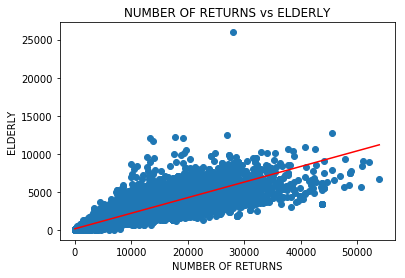

In [33]:
plt.scatter(test_x,test_y)
plt.plot([x_min,x_max], [m*x_min+b,m*x_max+b], 'r')

plt.title("NUMBER OF RETURNS"+" vs "+"ELDERLY")
plt.xlabel("NUMBER OF RETURNS")
plt.ylabel("ELDERLY")

plt.savefig("images/Number_of_Returns_vs_Elderly.png")
plt.show()

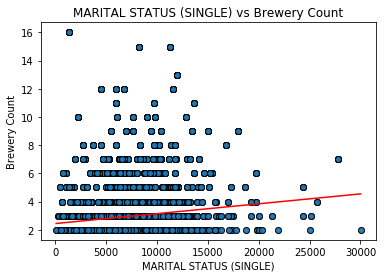

slope: 7.012925223916591e-05
intercept: 2.4379414638930563
coefficient: 0.17448359317330878
p-value: 1.226727189524184e-11
standard error: 1.0266479376072425e-05
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


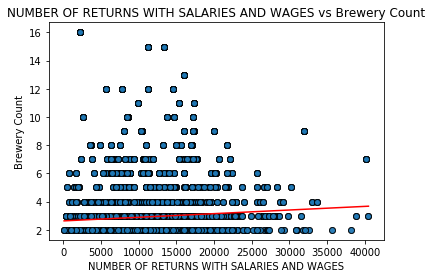

slope: 2.5764312602158036e-05
intercept: 2.6259174308981827
coefficient: 0.10431519332559633
p-value: 5.5412881930189655e-05
standard error: 6.372145961291813e-06
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


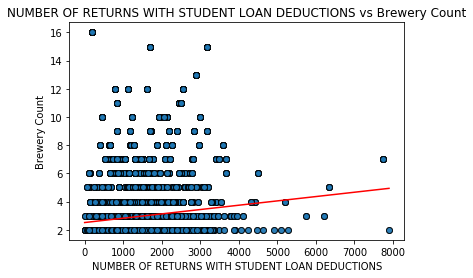

slope: 0.00030702814398387657
intercept: 2.510253992487154
coefficient: 0.17293174006679898
p-value: 1.8700507698031077e-11
standard error: 4.536293205563683e-05
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


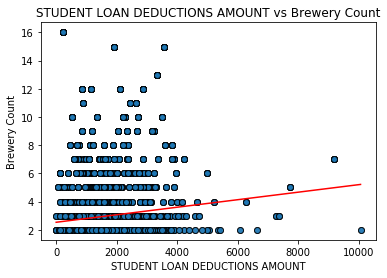

slope: 0.0002667975777081828
intercept: 2.5290247685721057
coefficient: 0.17317898352993605
p-value: 1.7490116339581415e-11
standard error: 3.9360914674097066e-05
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


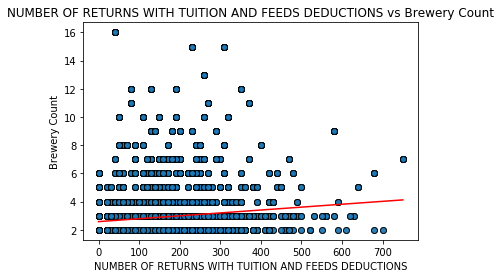

slope: 0.002054735273175242
intercept: 2.5754948229523524
coefficient: 0.15015961443840714
p-value: 5.866829374341786e-09
standard error: 0.0003509466224379716
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


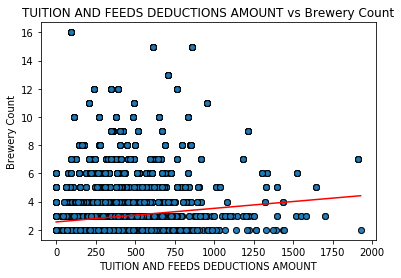

slope: 0.0009658685329787248
intercept: 2.551265204201646
coefficient: 0.16840720363702247
p-value: 6.254461404630545e-11
standard error: 0.00014665619749406724
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


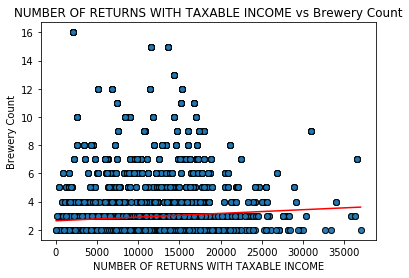

slope: 2.623420858153334e-05
intercept: 2.6337313702360152
coefficient: 0.10190671835234036
p-value: 8.217615812460291e-05
standard error: 6.643376796561597e-06
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


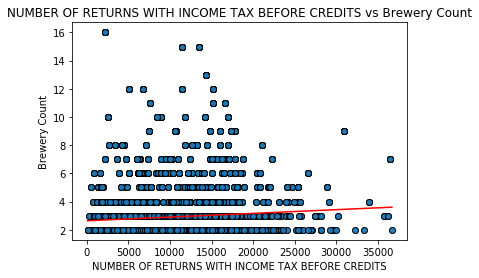

slope: 2.628381327214286e-05
intercept: 2.6345534537179662
coefficient: 0.10168839224275812
p-value: 8.512886579402564e-05
standard error: 6.670378533040518e-06
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


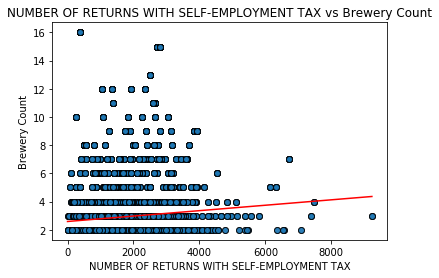

slope: 0.0001922438312858498
intercept: 2.5840518229404457
coefficient: 0.13101471938470366
p-value: 3.9475948119814117e-07
standard error: 3.773664236181513e-05
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


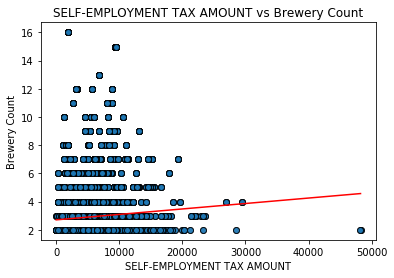

slope: 3.866663666412653e-05
intercept: 2.7004771146673936
coefficient: 0.10471797866412692
p-value: 5.183586849118068e-05
standard error: 9.526017715809827e-06
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


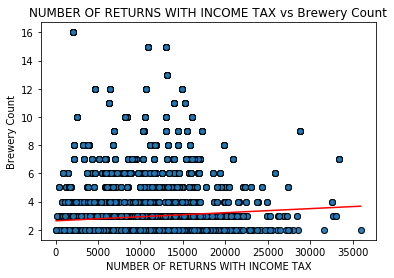

slope: 2.8836343613731567e-05
intercept: 2.6324223676532625
coefficient: 0.10352441452337034
p-value: 6.312576319600943e-05
standard error: 7.187009359483893e-06
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\


In [35]:
y= "Brewery Count"

for x in quant_columns:
#     m,b,x_min,x_max= regression_func(full_merge_df[x],full_merge_df[y])
    mask= ~np.isnan(brewery_zips_plural_no_dups_df[x]) & ~np.isnan(brewery_zips_plural_no_dups_df[y])
    m,b,r,p,st_err= linregress(brewery_zips_plural_no_dups_df[x][mask],brewery_zips_plural_no_dups_df[y][mask])
#     m,b,r,p,st_err= linregress(full_merge_df[x],full_merge_df[y])

    x_min= brewery_zips_plural_no_dups_df[x].min()
    x_max= brewery_zips_plural_no_dups_df[x].max()

#     plt.scatter(
#         brewery_zips_plural_no_dups_df[x],
#         brewery_zips_plural_no_dups_df[y],
#         alpha= .75
#     )
    
#     plt.plot([x_min,x_max], [m*x_min+b,m*x_max+b], 'r')

#     plt.title(x+" vs "+y)
#     plt.xlabel(x)
#     plt.ylabel(y)

#     plt.show()
    
#     print("slope: "+str(m))
#     print("intercept: "+str(b))
#     print("coefficient: "+str(r))
#     print("p-value: "+str(p))
#     print("standard error: "+str(st_err))
#     print("/\\"*30)
    

    if abs(r) > .1 and abs(r) != 1:
        plt.scatter(
            brewery_zips_plural_df[x],
            brewery_zips_plural_df[y],
            alpha= .75,
            edgecolors='k'
        )
        plt.plot([x_min,x_max], [m*x_min+b,m*x_max+b], 'r')

        plt.title(x+" vs "+y)
        plt.xlabel(x)
        plt.ylabel(y)
        
        plt.show()
        
        print("slope: "+str(m))
        print("intercept: "+str(b))
        print("coefficient: "+str(r))
        print("p-value: "+str(p))
        print("standard error: "+str(st_err))
        print("/\\"*30)

#     #     plt.savefig("images/Number_of_Returns_vs_Elderly.png")

#     else:
#         print("!/\\"*30)
#         print(x+" vs "+y+" failed to produce a chart.")
#         print("slope: "+str(m))
#         print("intercept: "+str(b))
#         print("coefficient: "+str(r))
#         print("p-value: "+str(p))
#         print("standard error: "+str(st_err))
#         print("!/\\"*30)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYIAAAEWCAYAAABrDZDcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsnXl4XFd5uN9vZjSjXbI22/ISx068JE6AxATIZrO12KQsXYEk2AZiKG3ZS1l+tKErCU1YSgsEGtsJO4G2FBJKGrCTEBLqBIcs3hPHi2Rbli1ZlrXP9/vj3pm5M3NnNJJmNCPpe59nHs0953zbOVf33OXcb0RVMQzDMGYugWI7YBiGYRQXmwgMwzBmODYRGIZhzHBsIjAMw5jh2ERgGIYxw7GJwDAMY4ZjE4ExLRGRb4vIm4rtx1gRkdkisktEIsX2xZg52ESQIyJyUEQGRaQppXyniKiILEopv9ktvyKlfIOIjIjIWRE5IyJPish1nvpFrlxIRO5z250VkSHXfmz7Kx6Z80UkKiL/5uO3isgFOcRXLyJ3isgxEekRkb0i8lcistBj86yrr9ezfU22mEXkE562/Z7Yz4rIM954U/zZIiJ/734Pi8htInLElXteRD6XJZZLgRcB/5WLvDu2r/GMj4rIX6boPCIiazzbF4rId0Skwx3HfSLyLyIy361fIyJHMvi3JWUsz4rIkwCqehz4BbBplCGbEK5/UY/9oyLy6ULanCxEZK6I/LuItLv78m4R+bSIVBXY7s0i8o1C2igUNhGMjeeBt8Y2ROQSoCK1kYgIcCNwCljvo+dXqloN1AP/BnxHROpTG6nqWlWtdtt+E7g1tq2q7/E0fTtwGnjLBM4kPwdUAyuAOuANwAFVPeSxWe22fZGn7KFsMavqP3pk3xOL3f1cnKNvHwdWAVcANcArgd9kaf9u4JuaeFtyrPKngL8SkVq/SndifQxoA16iqrXAVcAB4OocY/KOZbWqvshT9003hkLT5hmbq4F3ZrqKSp2oJ4ux2hWRBuBXOP+Xr1DVGuC1OP9rS/Lv4fTAJoKxcTfOQTfGeuAun3bXAK3A+3EOzmE/ZaoadXVWARdOwK+3A/8PGAJ+b5w6Xgp8S1VPq2pUVXer6j1jkM8p5gn49h+q2qYOB1XVr99jrAW2T0B+F87B5IMZ6m8GfqmqH1LVIwCqekJVP6+q38k5qsw8BiwWkfNSK0Tk5e5VW9BT9mYR+a37/QoR2eFepRwXkdtzMaiqzwOPABd59KqI/JmI7AP2uWXLReR+ETklIntE5I/d8vNFpEtEAu7210XkhEfXN0TkA+73Os8Z+1ER+ftYPO4V2S9F5HMicgr4O9fWJR5dLSLSJyLNPqF8COgBblDVg25sh1X1/aoa66MrReT/RKTb/XulR3f86tDdjp/le65e14vIIRE5KSKfdOteB3wC+BPvFd5UwSaCsfEoUCsiK9wd908Av0vB9cB/A991t6/zaYOrYyPOAfyF8Tgkzq2Z+cB3gO+RPFGNhUeBfxCRjSIynkkpp5jHyaPAh0TkvSJyiXv14Yt7+X8+sGc88h4+BXzQPcNM5TXAD8bg/5hQ1WFgP87trdS6R4Fe4FWe4rcB33K/fwH4gnuVsgRnnxgVd8yvwukrL28CXgZc5Pbt/a6tFpyr438TkYvdieQM8BJX7hrgrIiscLevJTE5bwWGgQvc9r8DvMtj82XAc66Nv8XZt2/w1L8V+F9V7fAJ5TXAD92TLL84G4CfAF8EGoHbgZ+ISKNf+wxcDSwDXg38tYisUNWfAv8IfNfnCq/ksYlg7MSuCl4L7AaOeitFpBL4I5yz6yHgHtJvD71cRLqAfuCfcc5eTjA+1gP3qeppnH/QtSLSMg49f4FzS+LPgWdFZL+IrM1FMMeYJ8I/AbcA1wM7gKMikkl/7BZbzzjlAVDVncDPgL/yqW4CjsU2ROTP3bPhsyLytRziAfiIKxP7bE2p7/HEksq3cW9RikgNsM4tA+ek4gIRaVLVs+7EkYlW1/YZYC/OlcjDKW3+SVVPqWofzuR+UFU3q+qwqj6BMyH+odt2O7BaROa42/e42+cDtcCTIjIb54rtA6ra6+73nwPe4rHZpqr/4trow5k43ha72sC5BXl3hpgagfYsMb8e2Keqd7v6v43zfzyWK+lPq2qfqj4JPInPhD3VsIlg7NyNcwa2Af/bQm/GOdu5193+Js7B2XsZ+6iq1gOzgB/hnD2NGRGpwDkAfxNAVX8FHHL9GxPujv2Pqno5zj/T94DvZzgjTiWXmDMx7P4tSykvwzmooaojqvqvqnoVzsHxH4A7PWebXrrcvzWxgjHKe/lr4E89B7YYncBcj/4vueP5eZ84MvHPqlrv+aROTDWeWFL5FvD77vOg3weeUNXYFeU7gaXAbve2R7YrszbXdi1Ov8QOul4Oe76fB7zMO4HhTK6x/tkOrME5+38Q2Aasdj8PuWfp5+H0UbtHx1dxzv79bKKqj+FcBa0WkeU4VxI/yhBT0tj40Er61fcLwLwsMqkc83w/h/NsbUpjE8EYcf/hnsc5C/uhT5P1ODvGIRE5BnwfZ8d/a2pDVT0LvBe4UUReklqfA2/GOdP6N/e+8TGcHXq8t4difp3BucyN3WYZjZxj9qEd54C/KKX8fHxul7kT1r/iPBy/yKe+F+eh7VI/Y6PJp7TdjTPGn0ipegDnAFwQxHlAegHO2aafX8/i9M1akm8Loar7VPWtOAfWW4B7JIfVMqra7epJPTP2pic+DGxPmcCqVfVP3frtOCc1a9zvD+PcblpN4rbQYWAAaPLoqE1ZOOCXEnkrzu2hG4F7VLU/Qyj/C7zZc/WQShvOZORlIYkr+16g0lOXehKQjSmbytkmgvHxTuBV7kEnjojMw7lveB3wYvfzIpx/SN9bEaraCXwd5+xzrKwH7gQu8di7Cnix9+EaEBaRcs8nmKpIRD4lIi8VZ6llOc5D3y6S77WnMZ6YvajqCM7thX8QkUYRKRORt+IcpO9zbXxAnOWOFeIsq12Pc8acaeXPvTgHH8Yp7+XTOM9xvLdpbgauEZHb3fgRZ1lx2hVGSr+X5/h84gqcWzDZnht9C3gfztn39z32bhCRZvfsO3ZFMTKaQRGpxrk980yWZj8GlorIje44lbn7zApwJiGcq4obgAfdE4rjwB/gTgSq2o5zy+02EakVkYCILBGR1b4WE9yNc+JzA/5X4jFuxzk52iruw3YRmeeO1aU4+8ZSEXmbuy/8Cc6+9mNXfifOYocyEVlF4rZXLhwHFmWZhEqWKedwKaCqB1R1h0/VjcBOVf2Zqh6LfXAeTF0qIiszqPw8sM7dUXPCcwD+vNeWqj4O/JTkg/AzOP+gsc9Gv7CAzcBJnLOm1wKvd69asjHemL28F2fJ5m+BEzjPKV6vzpp6XJ9vw7kkPwn8GfAHqvpcBn13ANd7DrpjlY/jPgSNreyKle0FXo7zkP5JEekBfonTb5/yiM8jud/7SCxh/Kgkv0dw0iN3PfAVsvNtnDPvn6uqV/Z1wDMichbnwfFbspw9t8bs41xhNLi2fVHVHpwHu29xYz2GM+F7lyxvBzpV9ZBnW0iedN8OhIFnca7M7iH77Rzc1VlP4OynD2Vpdwq4Eucq8zF3bB4AuoH97onXdcCHcW4jfRS4ztOHn8IZo9M4JwHfIndiE3KniDwxBrmiI2o/TGNMQ0TkW8D3VPU/i+3LWHAf9G/HeT8h0wF8RiIid+I81/h/xfZlumETgWEYJY84b+7vxJkgny+uN9MPuzVkGEZJIyJ/BzwNfNYmgcJgVwSGYRgzHLsiMAzDmOEUJZHUWGlqatJFixYV2w3DMIwpxeOPP35SVUd9sXNKTASLFi1ixw6/1ZqGYRhGJkQkpxxmdmvIMAxjhmMTgWEYxgzHJgLDMIwZjk0EhmEYMxybCAzDMGY4BZsIxPkh9BMi8nRK+V+I8xN3z4jIrYWyPx5EhFBtc/yTW6JIwzCMqU0hl49uAb6EJ2WsiLwSeCNwqaoOyPh+SasgiAjhucuoX7OByLzlDBzdTde2LYgI9va1YRjTmYJdEajqgziphb38KfAZVR1w24z35xnzTrCmifo1G6hYeAmBYBkVCy+hfs0GgjVNxXbNMAyjoEz2M4KlOD/o8ZiIbBeRl2ZqKCKbRGSHiOzo6PD7jer8E5m33GfbrgYMw5jeTPZEEML5nd6XA38JfC/TLzap6h2qukpVVzU35/LTtxNn4Ohun217TmAYxvRmsieCI8AP1eHXQBQoiXsvIz0n6dq2hb5DTxEdGaLv0FN0bdvCSM/J0YUNwzCmMJOda+g/gVcB20RkKc7P1ZXEkVZVERE6f3wbzu0gYaTnpD0oNgxj2lOwiUBEYr+p2iQiR4C/wfmh9TvdJaWDwHotoSNtCbliGIYxaRRsIlDVt2aouqFQNg3DMIyxY28WG4ZhzHBsIjAMw5jh2ERgGIYxw7GJwDAMY4ZjE4FhGMYMxyYCwzCMGc6U+PF6o7gEAgEC1Y3x7ejZTqLR6LS3bRgzBZsIjKwEAgHK5ixNS88dCAQKfkAupm3DmEnYrSEjK4HqRt/03N6z9Olo2zBmEjYRGKNSzPTclhrcMAqPTQTGqBQzPbelBjeMwmMTgZGV6NlO3/Tc0bOd09q2Ycwk7GGxkZVoNEogEEhKzz1ZK3eKadswZhI2ERijUswDrx30DaPw2K0hwzCMGY5NBIZhGDMcmwgMwzBmODYRGIZhzHBsIjAMw5jhFGwiEJE7ReSE+0P1qXUfEREVkaZC2TcMwzByo5BXBFuA16UWisgC4LXAoQLaNgzDMHKkYBOBqj4InPKp+hzwUSxhjGEYRkkwqc8IROQNwFFVfXIy7RqGYRiZmbQ3i0WkEvgk8Ds5tt8EbAJYuHBhAT0zDMOY2UzmFcES4HzgSRE5CMwHnhCROX6NVfUOVV2lqquam5sn0U3DMIyZxaRdEajqU0BLbNudDFap6snJ8sEwDMNIp5DLR78N/ApYJiJHROSdhbJlGIZhjJ+CXRGo6ltHqV9UKNuGYRhG7tibxYZhGDMcmwgMwzBmODYRGIZhzHBsIjAMw5jh2ERgGIYxw7GJwDAMY4ZjP15vTFlCoRBUzkoUnDvN8PBw8RwyjCmKTQTGlCQUChFsuYD6NRuIzFvOwNHddG3bQigUssnAMMaI3RoypiaVs6hfs4GKhZcQCJZRsfAS6tdsSL5CMAwjJ2wiMKYskXnLfbbtZy4MY6zYRGBMWQaO7vbZluI4YxhTGJsIjKnJudN0bdtC36GniI4M0XfoKbq2bYFzp4vtmWFMOexhsTElGR4eJhQK0fnj23BuB4mtGjKMcWITgTFlsYO+YeQHuzVkGIYxw7GJwDAMY4ZjE4FhGMYMxyYCwzCMGY5NBIZhGDMcmwgMwzBmOAVbPioidwLXASdUdaVb9lng94BB4ACwUVW7CuXDVCMcDhMtr4tvB/q7GRwczIvsRHSXCtMhBsMoRQr5HsEW4EvAXZ6y+4GPq+qwiNwCfBz4qwL6MGUIh8NI02IaU7JphsPhUQ92o8lORHepMB1iMIxSpWC3hlT1QeBUStnPVDX2FtCjwPxC2Z9qRMvrfLNpes+Axys7Ed2lwnSIwTBKlWI+I3gHcF+mShHZJCI7RGRHR0fHJLpVPCaSTXM02emQqXM6xGAYpUhRJgIR+SQwDHwzUxtVvUNVV6nqqubm5slzrohMJJvmaLLTIVPndIjBMEqRSZ8IRGQ9zkPk61XVTudcAv3dvtk0A/3dE5adiO5SYTrEYBilihTyWCwii4Afe1YNvQ64HVitqjnf71m1apXu2LGjID6WEolVMU42zfGtGvKXnYjuUmE6xGAYk4mIPK6qq0ZrV8jlo98G1gBNInIE+BucVUIR4H4RAXhUVd9TKB+mGhM5qI0mOx0OmNMhBsMoRQo2EajqW32K/71Q9gzDMIzxYW8WG4ZhzHBGnQhE5O5cygzDMIypSS5XBBd7N0QkCFxeGHcMwzCMySbjRCAiHxeRHuBSETnjfnqAE8B/TZqHhmEYRkHJOBGo6j+pag3wWVWtdT81qtqoqh+fRB8NwzCMAjLqqiFV/biIzAPO87Z3cwkZJUJ5eTnD4Zr4dmiwh/7+/iJ65FCqfsUodf8MYzIYdSIQkc8AbwGeBUbcYgVsIigRysvL0YZFaZk5y8vLi3pQK1W/pop/hjFZ5PKw+M3AMlVdp6q/537eUGjHjNwZDtf4Zub0numaX+mUun+GMVnkMhE8B5QV2hFjYpRqZs5S9StGqftnGJNBLm8WnwN2isgDwECsUFXfVzCvjDEzcHQ3FQsvSdouhcycpepXjFL3zzAmg1yuCH4E/B3wCPC452OUCKHBHt/MnKHBHvMrC6Xun2FMFgXNPpovZkr20YmQWP3iZOYsldUvpepXjFL3zzAmQt6yj4rI8/jcNFXVxeP0zSgApXrwKlW/YpS6f4YxGeTyjMA7m5QDfwQ0FMYdwzAMY7IZ9RmBqnZ6PkdV9fPAqybBN8MwDGMSyOXW0GWezQDOFYIttDYMw5gm5HJr6DbP92HgIPDHBfHGMAzDmHRyyTX0yslwxDAMwygOufwwTZ2I3C4iO9zPbSJSNxnOGYZhGIUnl1tDdwJPk7gddCOwGfj9bEIicidwHXBCVVe6ZQ3Ad4FFuLeYVPX0eBwvFlVVVQwEK+PbkZFz9Pb2FtGjBBP1bbzyo8kVs89KebwMo1TIZSJYoqp/4Nn+tIjszEFuC/Al4C5P2ceAB1T1MyLyMXf7r3J1tthUVVUxXLcgLVtlVVVV0Q8uE/VtvPKjyRWzz0p5vAyjlMglxUSfiFwd2xCRq4C+0YTc3ys4lVL8RmCr+30r8KYc/SwJBoKVvtkqvWecU9W38cqPJlfMPivl8TKMUiKXK4L3AHd5ngucBjaM095sVW0HUNV2EWnJ1FBENgGbABYuXDhOc/mnlLNVTtS38cqPJlfMPivl8TKMUiGXF8qeVNUXAZcCl6rqS1T1yUI7pqp3qOoqVV3V3NxcaHM542SnTN0ujWyVE/VtvPKjyRWzz0p5vAyjVMj24/UfEpF3xrZV9YyqnhGRvxCRD4zT3nERmevqnwucGKeeohAZOeebrTIycq7Yrk3Yt/HKjyZXzD4r5fEyjFIiY/ZREXkauExVB1PKI8D/qeqloyoXWQT82LNq6LNAp+dhcYOqfnQ0PaWUfTSxCsXJVllKq1Am6tt45UeTK2aflfJ4GUahyUf2UU2dBNzCAREZ9dpaRL4NrAGaROQI8DfAZ4DvuVcah3AS2E0pSvkgMlHfxis/mlwx+6yUx8swSoWsD4tFZLaqHk8ty0Wxqr41Q9Wrc/TNMAzDmASyPSz+LPATEVktIjXuZw3w38A/T4p3hmEYRsHJeEWgqneJSAfwt8BKnJuszwB/o6r3TZJ/hmEYRoHJemvIPeDbQd8wDGMak8ubxYZhGMY0xiYCwzCMGU4uv1AWVNWRyXDGyI26ujp6NRzfrpJBuru7Jyw7Eb3j8S9f9sbDRG0Xy/di9pkxfckl19B+EbkH2KyqzxbaISM7dXV19FfNTcuoWVdXN+oBIZssMG694/FvInFMlInaLpbvxewzY3qTy62hS4G9wNdF5FER2SQitQX2y8hAr4Z9M2p6zxLHIzsRvePxL1/2xsNEbRfL92L2mTG9ySXpXI+qfk1VrwQ+ivOGcLuIbBWRCwruoZHGRDJqZpPNV6bOXPVM5aykxfLdsqkahSCXn6oMisgbROQ/gC/g/Jj9YpwXy+4tsH+GDxPJqJlNNl+ZOnPVM5WzkhbLd8umahSCXG4N7cP5QZnPuimob1fV46p6D/DTwrpnpFIlg74ZNaskLS3UmGQnonc8/uXL3niYqO1i+V7MPjOmNxmzj4JzNQB8UlX/dvJcSqeUso+WAomVI05GzfGtGkqXnYje8fiXL3vjYaK2i+V7MfvMmHrkI/soqjoiIq/ESTNhlAgT+cfPJpuvA0queop5AJuo7WL5bgd9oxDksnz0ERH5EvBdIJ7TV1WfKJhXhmEYxqSRy0RwpfvXe1WgwKvy745hGIYx2Yw6EajqKyfDEcMwDKM45LJ8dLaI/LuI3OduX+T9LWPDMAxjapPL8tEtwP8Are72XmC8P15vGIZhlBi5TARNqvo9IAqgqsOAJaEzDMOYJuTysLhXRBpx32MXkZcDE1rDJiIfBN7l6nwK2Kiq/RPRWUxEhGBNU3x7pOckfu9nNDU30zWQ2K6PwMmOjpzrszER2ULqT5Ub6TkJkNRfo+ny0zEW+VKm0ONmGLmQy0TwYeBHwBIR+SXQDPzheA2KyDzgfcBFqtonIt8D3oJzC2rKISKE5y6jPiUjpIgkTQZNzc30lDXS+Nrkdk3NzZzs6Bi1PhsTkc2F8epPkmtdzkDbbrq2bWawfT+N133YU5ZZV6rtw1+83re/8xXrZFLocTOMXMkl6dzjwGqcZaTvBi5W1d9O0G4IqBCREFAJtE1QX9EI1jT5ZoT0nrECdA3g2y52NjhafTYmIpsL49XvlZNgiPIFK6lfs5FgTUNKWWZdqbaDkUrq12ygfMHKgsQ6mRR63AwjV3JZNfQQ8GlgAfCCqg5NxKCqHgX+GTgEtAPdqvozH7ubRGSHiOzoKPGzo3xl2yxUVtF8MF79aXKt6XKj6fK3PXZfSpHpFIsxdcnlYfF6YA/wBzhvGe8Qkc+N16CIzMJJYnc+zkqkKhG5IbWdqt6hqqtUdVVzc/N4zU0K+cq2WaisovlgvPrT5NrS5UbT5W977L6UItMpFmPqksutoeeA+4EHgAdxbuWsmIDN1wDPq2qHe3XxQxJvL085RnpO+maEjD0UjVEfwbddfSS3+mxMRDYXxqvfK6cjw/QffpqubZsZ6TmVUpZZV6rtkYFzdG3bQv/hpwsS62RS6HEzjFzJmn0UQEQOACeBbwEPATtVNTpugyIvA+4EXgr04Twk3qGq/5JJptSzjyZWDTkZIUdfNeS0y7xqyL8+GxORLaT+VLnkVUO56fLTMRb5UqbQ42bMbHLNPprLRPB+4GqcZwS7ge3Ag6p6YALOfRr4E2AY+A3wLlXN+Iis1CcCwzCMUiRvE4FHYTWwEfgIMF9VgxNzMXdsIjAMwxg7efk9AlfRbThXBNXAr4C/xrlFZBiGYUwDcnmh7FHgVlU9XmhnDMMwjMknl+WjPwBeKyKfAhCRhSJyRWHdMgzDMCaLXCaCfwVeAbzN3e5xywzDMIxpQC63hl6mqpeJyG8AVPW0iIQL7JdhGIYxSeQyEQyJSJBE9tFm3JTUM4X5CxZwrDuRHHVOXTlHDh/OWD/S00mwpjGtXa4Eg0GkqiG+rb2nmNvammZj3vx5vvrnL1jA0SNHCdY0xn1BFUTi29p7KsmGn6/euOJ6UmKM+eenK1O/+Mn4xZOp3/30ZuqL0eIYLe5MbQwDps++kst7BNfjrPm/DNiKk3n0/6nq9wvvnkMxl4/OX7CAjpGqtGyXzcHe+EEpXu/JpjnU1U5Z/dx4u1wJBoOEZl+YYm8zg8cO0PKWv0+yMXhsP/PmzU07eB492k54zgVxHzL5NtTVzvw/25oWU2rcJ//7nwnVNFK/ZmOSnuEzJ2l6w0fiOr26ho/vS8Thlek5iY4MUVY/J02fN55M/e7ovSCrbKbxc+JoSvMpU9x+420YMabCvpLr8tFcUkx8E/go8E84SeLeNJmTQLE51t3vmyEydhYQqy9fsBIJhuL1gVA4qV2uSFWDj72NBKtnORk3Q54Mp9Wz0vQf6+4nWD0ryYeYb7FMn7HyQCjsG1Nq3CJC/ZqNaXokIEk6vbq8cSTJiLj2N2aNJ1O/O3qzy2YaPyeO9LHKFHemvjEMmF77StZbQyISAH6rqitx3iqekYw3a+h4M0nmM2Nnrr756fPKOj7428+kK3O/SVZ9fvaT9OYgmzGOHLJ9WkZQI1emy76S9YrAzSn0pIgsnCR/SpLxZg0dbybJsWXs9Ncf05Grb36+emUdH/zsZ+oPydpvmfXl0K85yGaMI4dsn5YR1MiV6bKv5LJ8dC7wjIg8ICI/in0K7VipMKeu3DdD5Jy68qT6/sNPoyPD8fro8GBSu1zR3lM+9jYzcva0k3Fz2JPh9OzpNP1z6soZOXs6yYeYb7FMn7Hy6PCgb0ypcasqXds2p+nRqCbp9OryxpEko+ra35w1nkz97ujNLptp/Jw40scqU9yZ+sYwYHrtK7k8LF7tV66q2wvikQ/FzjWUWBng3NbIvGoolh0zX6uGHH3Jq4YSNvKzasg/ptS4RnpOuattvDE2xP3z0+XfL/4y2VcNja43t1VD6XGMFnemNoYBpb+v5D3pnKu0CejUsQjlgWJPBIZhGFORCa8aEpGXi8g2EfmhiLxERJ4GngaOi8jr8umsYRiGUTyyrRr6EvAJoA74ObBWVR8VkeXAt4GfToJ/hmEYRoHJ9rA4pKo/c98ZOKaqjwKo6oxdRmoYhjEdyTYReNNI9KXUTb2FsoZhGIYv2W4NvUhEzuAsiq1wv+NuT731UYZhGIYvGSeCyfwpSsMwDKN45JJ9NO+ISD3wdWAlzm2md6jqrybL/rLlyznQ1hnfdtaWO5kwl7Q2smd3/h6DpNpa0upkvjzQ1pmwG1/j72yP9JwkWNMUlwn0dxMtr/P469SnysfajfScAojH5JXxxhxvk2I/1U+v77G+WbZ8OXv37Euy4Sfj1TnSc5Kly5ZlrE+NM9NY+PXpeMcsV12Z2mXal/K9H+WbfPahMfUZ03sEeTMqshV4SFW/7v62QaWqdmVqn8/3CJYtX87BM6RloBzpP0vj6/6crm1bWFRLXv4pkmy52QlPfPevCc9ezPDZTkLVjenZOd3y4bOdzNv0NY7ecZNvu8H2fYTnpmf3HGzfB4Eg4dmLU+o2M3z2FPM2fY2Btpgf56dk8dzMSF8vjWv/PO5nambFRbVObHv3PZdmI0nGt283M3j8eVr+5G/T6nV4IBFnij3vWPj16XjHLFddmdrpyeeQpvR4Y2OYr/0o3+SzD43SJm/ZR/ONiNQC1wL/DqCqg9kmgXxzoK3TNysmwwPx7IHeM6V82YplJwxW1TlZNME3M2isXAAJhjK2C9Y0ZCyP2Uiu2xhUiK5JAAAgAElEQVTXWb5gpdsmNaPoRhgZ8NSnZ1Y80NbJgbbO5PpQWZqMf99uJFhV51vvjTPV3mh9Ot4xy1VXpnbR8uR+jmdIdWPJ136Ub/LZh8b0YNInAmAx0AFsFpHfiMjXRaQqtZGIbBKRHSKyo6OjI68OZMsYmO/sgam2IJHJc2yZQTO1Sy/3lfHLYJqaxTOlzWhZPrPF5uvTKFlUc83kmM+MjxO1me/Ms5PFdMmaaeSHYkwEIZwfufmyqr4E6AU+ltpIVe9Q1VWquqq5uTmvDmTNipnn7IGptiCReXNsmUEztUsv95Xxy2CamsUzpU22jKOjxebrU9YsqrlncsxnxseJ2sx35tnJYrpkzTTyQzEmgiPAEVV9zN2+B2dimBSWtDb6ZsUkFIlnD4w99MynrVh2wpHebuf+MvhmBo2VK6AjwxnbjfScylges5Fctzmus//w026b1IyimyEY8dSnZ1Zc0trIktbG5PrhoTQZ/77dzEhvt2+9N85Ue6P16XjHLFddmdoF+pP7OZ4h1Y0lX/tRvslnHxrTg2I9LH4IeJeq7hGRm4EqVf3LTO3znXQusWIilr3yFMGaWYAUcNWQxvVDrquGHJnEapqYv2NZNZQs44053ibJ/qw0P72++68aSo/Nr2+TVw2l16fGOfoKnuztxjs+Y7Hpvy9NpVVDE+9Do3QpSPbRfCEiL8ZZPhoGngM2qurpTO0t+6hhGMbYyXUiKMp7BKq6ExjVOcMwDKPwFOMZgWEYhlFC2ERgGIYxw7GJwDAMY4ZjE4FhGMYMxyYCwzCMGc6MmQiuuOJlhGpbCNU2E6pt4YorXpZWLoGQU1/TlLQdL/fIZdNdVVXlaysXf/zb+fgS81HEx8/k7+k+OXJpMm5ZxjbefnG/BwKBZBmPvqqqKq644mUpvjQnxepXL4FQIiaf+Pz8iZVVVaVlK/Ht6zHtDxnGKNcxHCvj1Vsof0qNmRLnZFKU9wjGykTfI7jiipfx5JHutGyLoe7DDNctoH7NBk7/4k5EJCUb5xZGBnoJRipRVWa98h10bdvCi+bX8etfP+aru+3OvyAYqUqzlU3Gr423neNDVfxvalbRwY4XCNY2x+tO//xOJBBIzwI60Evrxn9JZCo9nsggeuJ7NxNuWZSezfR4epbRrm1b0GiU6FCfjz9O3axXvcPNhrqH8NxlaW1eNN9JN/1/v3mScPN5af0+2HGQYG0zI2c6CDefx8jAuSx9kGgfjFQR6j5Mb29v1r4e7DhIyx/dPMr+kN6HsTHKdQzzta+OprdQ/pQaMyXOfFGy2UeLwRO7n/fNtjgQrIyXR3tPJ2XjjLVhqJ/6NRuJ9p6Olz2x+/mMup326Vk0s8n4tfG2i+n06vZmDA1W1CTVRc+d9s1MylB/cqZST5bSYGWNfzZT30ymG4ieO53BH6cuFlOwpiktS2ks1id2P0+wosYnC+qGeEyx+ux9sCGpDwaClaP2dbCiJof9IT2zaGyMch3DfO2ro+ktlD+lxkyJc7KZERPB6Fki3bIMmTO9WTOdMu/POWfSnbqdi0yUZDQtU2m2rKJJsYySXdI3/vFkOc0h26i/z9EcdCTXZ+wDT/v0LJqZ7PtnQR29P2JjlOsYjpXx6i2UP6XGTIlzcpkhE8FoWSLdsgyZM71ZM50yb7dl0p26nYtM6nBIWqbSbFlFk2IZJbukb/zjyXKaQ7ZRf58DOehIrs/YB5726Vk0M9n3z4I6en/ExijXMRwr49VbKH9KjZkS5+QyI3rvsuXn+2ZbjIyci5cHqmYlZeOMtaGsnK5tmwlUzYqXXbb8/Iy6nfbpWTSzyfi18baL6fTq9mYMHenrSaoLVM7yzUxKWXlyplJPltKRcz3+2Ux9M5luIVA5K4M/Tl0sppGek2lZSmOxXrb8fEb6enyyoG6JxxSrz94HW5L6IDJybtS+HunryWF/SM8sGhujXMcwX/vqaHoL5U+pMVPinHRUteQ/l19+uU6Ul770Cg3WNGuwplGDNc360pdekVaOBDVY06TB6kYN1jTFt52/yXLZdFdWVvraysUf/3apvnh8hPQ6byy+PjlyaTJuWcY23n5xv4tIsky8r5q0srJSX/rSK1J8aUqK1a8eCSZi8onPz59YWWVlZU59Pab9IcMY5TqGY2W8egvlT6kxU+LMB8AOzeEYOyNWDRmGYcxEbNWQYRiGkRNFSUNtGIYx44lGobMT2tv9P8eOOX+3boWrriqoKzYRGIZh5JOhIecgHjuQZ/ocPw7Dw+nytbUwd67zueIKqKxMb5NnbCIwDMPIhd5e/zP21M/Jk+myItDcDHPmOAf4lSsTB3vvZ86cSTnwp2ITgWEYMxdVOH06+62Z2KenJ12+rCxxcD//fLjySv8DfEuL07ZEsYnAMIzpx/AwdHRkvzUTu30zMJAuX1WVOIi/+MWwdm3igO/9NDRAYOqvuSnaRCAiQWAHcFRVryuWH4ZhTCH6+0e/NdPe7kwCUZ+0Ew0NiYP40qXpt2Vi32tqJj+2IlLMK4L3A7uA2sk02tTcTJfnBKA+Aic7OuLb69a9np89/Ov49kjPSYI1TWnfM20TKCNYVcdIbzfBqjrn0lPE2a6sdb6f62bt77yWe+/9Sbq93m4AR9bdjn9PtdfbDdEhQnUtvPbKVfzv/95PtLwuScbbLh5HNt9S7I/aB73dNDbU0T0UQKPR5LZ+ulJsxb/H5Dw+xXyO1fn6XeUfr7d8pLcbBIKVyW1CNbN47ZWruPfen8TH/v5HdqDRKBII8NorneXXqWWx9plIG1PPeGeTGaudXMlXXAVDFc6cye3+e1dXunwgALNnOwfwefNg1Srf2zNvuGkT9z32G/TQceRIB6+9Msy9d901+fGWIEV5oUxE5gNbgX8APjTaFUG+Xihram6mp6wxLYVtzVAnJzs6WLfu9Tyw80B6WmVg+HQ7ZbPm+tbNedtnGGjbzYkf/B3hxvkogkBa20CkmtpX/KGTBrnzMI21lQl/vCmVOw9T3roi3jYQqWZk4CyCpqdr7jzsBDd4jvDcZSj42h7sPEzLH3yKM7+6h+jA2bRU1oFIDbWv+MN4DKl2En0wx9eHssYFSX105lf30N+2i3Djgqz9kIgt1efNDHYeASDcuCBjXENJ47KMgbY9cX8FJ7XcUOdhXz9ibV794iUAPLDzALPWbCAybwUDR3dx/Ad/R7hxQVLZ6W1bePWLl2Q8aGbahwY7D7P21Wt85WIyY7GTK5l0D3YeZvYffCrv9pKIRp0Hp7ncf+/rS5cvL898xu79NDVBMDiufsh7zCVGri+UFWsiuAf4J6AG+MhkTQSh2mYar/swFQsviZf1HXqKzh/fxvCZDsrqZ9Ow7oNO6mERVJX+w0/T+ePbAaXxug9TvmBlXDZWN+9P7wTg6JffQeN1H6Lzx7fTeN2HMrbNRSeQ0paMOmOZNBuv+/CotmM+jqd+NH+99Ue//I6sPo8ltuxx3ZbRp9hYpOoXEXfcb6fpug/Ree/nnDbrPki5Z9848m8babzuQ0n7S/+hp+i893MMdR3Hj9R9CIjbkoD4ypXVz06zPZqdXPHTHfNn/ns3j8/e4KCz9HG0+++ZlkfW1fmvlkktq6tzVtvkgUL2cSmT60Qw6beGROQ64ISqPi4ia7K02wRsAli4cGHe7GdLqazRaIaUyFFAcksvnSn1sqdt0veM9vDUu/aztpWE7dR2rd522dJCe2PI0Aej+RDXnZ4aOy32bH3bmlqXWypxr2wufkfmrUCjI66dFSTj1xex9v5k24c0Q6ZkjUbTbI9mJ1d8dbcm72Mxe5Ujw7Bv3+j33zs70w3FlkfGDuKXXpr5QF9RMeG4xkoh+3g6UIxnBFcBbxCRdUA5UCsi31DVG7yNVPUO4A5wrgjyZXzg6O6kMzxv2mIJBBho2510dplIcasMHM1UF0OSUi9napukM6M9d7vNI5fFt0RbSW/Xlp4+OWt9tj7I6q+3jxKpsUfvB592bcn9nrlPM8eTpD+D3wNHdyGBoFu2K+mMMdYXyftLor0f2fYhCfif3UogkGZ7NDu5IiJUPreDBfVzaDl7mpbeU8w6sova/nMs/q9baOk9TfPZU7T0nKR6eNB5gOqlrCxxIF+yBK6+OvPyyFDpLkIsZB9PB4qadM69Ipi0W0P2jMCeEUybZwTDw3DixKj334cOH6HM51KkBzhR00hH3RyOBYIcPnmYqvktvOOTn0hfHpmn2zPFxJ4RjNJuJk0E4F015BwGMq8acuoTq2CUkZ7O+PfUutj2+FcNuTriK21q49vx76n2Rl01lNwuHkfvmRxXDeXQB0mrhkaS6kd6z6TryvuqodpEPF4bGVcNJdpkXjU0ggSCKatrEmW5rxpybY1h1VBkZJi5Irzh4qXc9pEPZz7Qnzjh9EMqjY1pZ+tf/a8fsf2Fo7QDx4IhVrxiFf2h0Jjjmur4je90j3lKTAS5YmmojSmNKnR357b+vbs7XT4YTCyPzJSWIPY3HJ78+IySpWQfFhvGtCEa9X971e9A39+fLl9RkTiAX3wxvOY1/gf6xsZRl0caxkSwicAwUhkczH7WHqs7fhxGfFad1NcnDuJXXpl5/Xtt7bS4/25MfWwiMGYOPT2jpwZub4dTp9JlRZyVMbGD+Ite5L80cs6coiyPNIyJYBOBMbVRTf5xj2wH+t7edPlwOHEgv/BCuPZa/3vwJb480jAmgu3ZRmkyPOz/9mrqgf7YMeeHQFKpqUkcxC+/PPOD1lmz7PaMMeOxicCYXPr6Rk9NEMse6beirakpcRBfsSLz/feqqsmPzTCmKqpa8p/LL79cx8u73nWTEirXYE2TBmualFBECUXc7UanLBiJ1wVrmhRwvzcmyxHwtGtMyBPQYE1jvD6pTXVjYru6Mcl+3I9qrx7PdswvAklt0+SS9HnqY7648jF9vjpisRFQghFfG2n6436GtR704so6fU1Frd5QXq0fRvT2snL9ViiiPxfRXYGAdiGqzuE96TMIelgC+utAUH8UDOtXJKB/I0H900iVvqm8Rl9eWafzES2TgKePY37jiTV5DBLjRnqfhCJKIKi1tbVJ/eRtU1tbG9+Hyupa4uWBSKUuXbZMKxpbNVTbrBWNrfqud92Utt/F6gORSi2ra1HKEvthqkysffL+434vK/e1MZb/gVx9zdXOeGTyRSHima4AOzSHY+y0fo/gpps28e/f/C5l9XOpX72e3qe3ce7Ao872mo3Om6hHd9G1fSuBilqi/WcY7ulEhwcpq59D/Wr3LcS2PXRt28xQVzs6PEy4aQH1q9cTmbeCjv/4R6J93QyfPUWo2nlLuPepXzDU+QL1q9cTbl3KYNteurZvZaSvh+jAWcrq5zr2+s64bZZx8j8/k7Q92L6Xru1bCJTXEu3rZqjrGM1v/Bhnn/45w52HM7Q7w0hfD8GKGse/1uUMtDtv2g4efw4pr6D5jR/n7FMPxHVEWpcx0L6Xrm1bGD7bSai6gcH2fYTnLqXh2rczt342sw4+SfWvf0jT2U7mVzcyZ6CXBQ3zmDMyTMuZEzT3dlFB+n50TgIcC0VoBzrnLKGz6TzaRoZ5/oUnOdJ3hoFXvZPnDz7Jsa5j1K3ZEI+n47/+ibK6uWn9N9i+h/DcZfG3dp2+P5OIo21PfCyb3/wJd2y3MHj8ecKzF8fHLGk8B/ooX/Rihk4ddfot9e3jk88RaF5M3bUJ2Y7//EfK6ucwa81GKhdcRP/RXZzatoUb117D1752BzfdtIm773uIhjUbOPP0zxk68UJ8/6pfvYHw3KUMte+l68Gt3Lj2GgDuvu8h6q9dT9ncpQy6cZQ1nkfVyjV0bd9KsKqWaF9P3MZY/gdivpTPW5HVV7/68egsJIWIZzpjL5QBlU3zGBweoXHt+ylfuJKjX90EqJOFcMHFbiul/9DTdN73RRrXfYDOH/8zBIJxmVjOnP7DzzhZKqMjNL7+Q/G6o1+9ica176PzJ7cnMm9+9SYa132A8gUXxW9v9B/ZldC97oN03vt5Gte+z/FDhKNf3UTjuvdTPv8i9561uDaddp33fYF5m+7g6B3vTtYtgUQ71//G6z6SUu9k6SQQZN67v07HV97FijUbWFDbSEvPKVrOddHQtofavY9wXvMiGo7tZ16kkqb+XkI+6QlOhyvoqGmio2oWJ6pm0aZRnj/4G9olyPAb/4oTVXUc6j7BCz/7Cog4cXr78tBTWeM5+tV3Jfo/3n/PpmUadfrZ7TOX/iPP0nnvF5j37q8lxvYntyeNWep4EghBdDhJdyJD6W1xWREnb9GRr7zT8W/BxYTcB8h9h56i66df5NzJo1Q2zaP+de+jYuElHPq3d9Kw7gPx8alYuBLVKKgy1LaLrp9+EYD6172PslY3KZoI/YefpfPezzPv3XfQf+hpTt33RZqv+0Dcxlj+B2K+xMjkq1/9eHQWkkLEM52xF8qAoaEhUCXcugwQiDopcSPzlnlaiVMfHU6UR0cSMi6RecucgwaaXBcddrc9mUTjumLZbmI2FaIjrq6EXMy3RBZN8dh028WyJGbSHR2moXkhDdERVkaHmL3rIVrOdtLS20XL2U7qznUzW6PM++LbmNXfAz+6JamvRiTACZSTw0MclgB7L3gZJ6tmcaK6kRPVszhWXsPT//1ZjkmAxvd8HQm4u45GiY4M0/61dwMwb+EloFG0vhV0BJS0vhwtnuT+92YxTckGmtRnJNpFY6mPJd7H2cYzsV/4ZzcNty5zs0fF7I54xs6hfN4KhoYGAWe/K3czXWosPs/+JQiKemSE8nkrGImfk0lcJhaDRoeTbOSK15fRfPWrH4/OQlKIeIxpPhGUlZUxODzCYNse52wwEMLJZrkn6YpgsG0PBEIMHN3jFAWCCZl4Fs09EAhCdCS5LhBy5PFkuHR1lS9InKk6ugUCQVeXI+f4oa7Mbvfs1slRM3B0DyJBap57nCaNcvHzv6FseIgl93+V1lAZLWdPOdkju47TfPYU1V98m2Psu59K2A2GOF5eTZsq+wIhnlhxDfuffZCeF/0uXQsu4oR7sD/SeYSOez9H46tvcs6CV76G8vkrElcnh56iMxSO+xX3G9z+C+I90A607Xb7m7S+TLTHt6+S+z/Wfz6ZVZP6zNMuNknFxtbHB+94xq4IMmU3jcnGJ4OYf/F9CPqP7qKsLBzf7/qP7qJi4SVIbL9y/1YsXIm6/eaV6T+6K3FF4O6jsf11sG0PEggltc8Vry+j+epXPx6dhaQQ8RgQvPnmm4vtw6jccccdN2/atGnMcgf37eGJnTsZOn6A0KxWdKCPwZMHGTq2n1DDPILVDQwceZau7VsJ1bbQd+AxooN96NAAQ8f3E5rVSrC60bnXvG0zI72niQ4OMNTxfLyu/4Xf0rffkRts20uooRXt7+Pcrm2EZrUSqJ7lZDndvgUdGSE6eI6hY/spr2mifu8jLEN40ZkTvOLoLl757DbefPhp3rZrO+985Dt84PEf8Y/9Z3nf7od4z2Afv//sNt40PMC1x/dzQccLVA4PcAZlV38PD1fV85/hSu4KhflqTRN3rNnI7a99L3+/eBWfPbafO3q7+F6knF9efT3bh4d47Nh+Di9eRefsJZzqOMjp7VvdGPYw3HmEoc7DhBrmEaiaFX+OMtJ7mnDLYvoOPObE5lNXuewqt7+2EKptIdy0iHO7tif35fYtjPSeJjJ3GdGB3nh9oLqBgaO76H32FwwdO5DSf1sZ7jzMUOcRQg2tBKsb4n3v6G6I+xKqbXH8OPIsXdu3MHz6GEMnD/mPZ99ZIq3LiA6cY/DoroTuI8/StW0LcuYYgycPEaqPle+i95lfMHR8P2UN8ymraaT/yDOc2raFG37vNbzhDb/HwX17eOx/f0TZrFZGBs9x7plt8f0r1m+Dbbs5vX0rN/zea7h0xVK3vdvfR5w+isxZRiBS6cRU38K5/b+O2xjL/0DMl1B1dl/96sejs5AUIp7pzKc//en2m2++efSHI7k8US72J3+rhhrHsWrIs2omtjooy6qh6upGvbCqXq8Klukfl1fr+8OV+plwhd4pAf1psEx3InrcvWnit4LmuIjuDAT1f4JlulkC+plwhf4Fon8YCOm1FXV6YWW9VgbDOa4aSvhX0FVD7socvz7x7a94+8yroNJWXRFQAsEsq4YaU1YNJdtK65O0VUPpsumrhhp9Vg2lrwCKycTqE6uGEiuBcls15PpaFsnTqqHRfR37qqHcZfJFIeKZrmCrhvKIqvOj2aOlJjh2zPkR7lRCofT17n7r32fPdn4IxDAMIw/Yw+JcGBlJ/LjHaEnGBgbS5Ssrk3PPvO51/gf6xkYIBNLlDcMwSoDpPRHs2QPPPJP5IH/ihJNKOJWGhsSB/JprMud/r6mx9ASGYUx5pvdE8IUvwJe/7HwPBJJ/3OOyyzL/yEckUly/DcMwJpHpPRF86ENw003OAb652X7cwzAMw4fpPRFccEGxPTAMwyh57AmmYRjGDGfSJwIRWSAivxCRXSLyjIi8vxB2br31ViL1swnVNBGqbSYQqSIQqSJU0+iU1TQRCFcRqm2O10sw7GzH6iNViIhTH2sb0xd227ttQ7XNiATjOgKRqjRdXruBcGWSb3G/PNtxmdpmJBhO9sGjMxBOtIv5Ed+uaUKCYUSCSfqS5Lz+ubZSYw3VNCb0uu0D4aqUOBtdWxKXSch7+0nivjp6JaEzUuWpc3z3joNXh0gwEUusz9w+SvItpstt7zeWodomguFyymLta5sJRKoJloWTdHh1ese/rH4269a9nltvvZXaxhZCtS2Eapspq2shXFVH65IVrFv3elqXrKCqaR6tS1Zw6623pu2zsfr6uedR29gSbzuarJ+ObO0A1q17PWX1s+MxhetaqG1soX7ueTnJT9R+ISi2/XwymbEU49bQMPBhVX1CRGqAx0XkflV9Nl8Gbr31Vv76C3dS97t/TnjOhQx1HKTzJ58jWFVP3TU3EJ69hMETz3Hm4W8RWbyK8gUr6d6+haEzHZQvfin1q9/O4LF9dPzg7wjPXUpZyxKGOw9Rd80NlDUvYvDYfrof/gbDPZ00rH0fkdblDB4/QNe2zQyfPUX54pc67a9+m9P+xHOcefjbRBZfRqR1Od0P3s1I72ka1r6PgaO7GXj+CWqvekvc1+6H7ibUOJ/hk0coX7yKyPwVnPzxbfHspmVNC+P+EwrD8CC1V7+NyNxlDB7bR9f2uyhrPo9Zr3wnA8f20f3gXQx2HqGsaQF119xIZM6FDBzb68S/6DIi81e4319M+YKLHfmW86lfvT7Jn6ETBylrXkSwponep/4XgFBNE/Wr11M2ZwkDR3fR/eDdjq3G+dRdeyMDR3YzcPAJaq++nsjcpQn/WhYx69WbGDjyDN0PfcNJutDbRaimibrV6wnPucDVdxeDx/YTnrvUzRgbywy6mcHOIzRe92EGjuym/7n/I9Q0n+HOI4Qaz6P/+cdTdD1L94N3owihutnxsRw68RzdD3+T6MgQUt1E3TXXE5l/EUPHDnDyx7cRrJpH3TU3EJm7LNFniy9npOcUQ8cPUHfN9YRnL2Go4yAPbL+L+352P5E5F9L4OzdQ1nJ+vP9OD0R5YOcBml+1gfPPv4TeI7v5+y9vBeCjH/0ot956K3//5W/QuOZdtDafz5lDu+h++FvULXsZfd0neGDn/oyy3v0+puP8+csztgNnEnhg5wEiiy6P79v9h55i4OBO6q5+G80LVzDc8XxG+Uz/d7naLwTFtp9PJjuWSb8iUNV2VX3C/d4D7ALm5dPG57+6mdqrr6e8dTnBcAXlC1Yi4XLqrrmB8tblBIJlVCy4hPrVG+jb80vK519E/eoNBCKVDLbvcWRalxOsrKN+zUYG2/dQf+3bKV+wkmC4gkjrUuquvoFApJLy1uUIUL5gJXXX3BDXUX/t24nMudC1dSn1q9fTt+cRKhZcQt011yPhcioWXELfnl9Sv3p9kq/1165nsH0/9avXc27Pw5QvWEkgUkndNdc73z3+D59qo371BioWXIoAkTkXUr9mA4Pt+xAR194NBCNV1F19AxULLomX16/eQN/eR9zv6+nb92hCvm1Pmj9119zIYPs++vY9ioTLkXC5k9p5/kUEQpFkW9c4tvr2PuL6d0myf217CYTClLcup37NRqJnT8f1lc+/iEAo7Oq7kWB1A/VrNjrjGAw5Pq3ZSDBSRfmClZzb8xD1q90+u3Y9g+17MuqKnj2VPJZzLqT+2vVEz3ZRv2aDs3+EIkTmX+TuMzc6Y+ztsz2PMNi2O9E+WBaPy9lnNhCZcwHBcCUVbv8N9XQya80Ggi1LCARD1Jy3ksY16/n8VzfH99nGNeupOW8lg8MjVCy8hPo1G+h6ZjvnjuzKKuvd72M6srUDuP+RHcxas8HZV1evp2LhJfTtezT+fXB4JKt8pv+7XO0XgmLbzyeTHUtRnxGIyCLgJcBjPnWbRGSHiOzo6OgYk97u7jOEZy9xknu5L3Lp0GC8LFYebl1KdOAcAOG5S9GhAWc7EIgnBou0Lic6cI5w61JHuZssLTx7CTo0kNDnKYu197UVCMTbEQgQHTzn2Pb4Gp7rtI399foPJHTOXQpEHd9cn9XN0BkdPJdoN3sJoM7fWGwxnwbPxXVFBxyZyLzlbnnQ408v4dlLiA6ec9oNDTo+xfoFfGwFnfhS/Yvpd2NxMopqVn1JWUeJZXp13gGJ9be3zzLriiaNpaLudpRI6/L4WI62z0QHzhGZt9wz/ok4Iq1LITaeIs44aZTIvBV43+Svmr+c7u7u+D5bNd+JUdXxLdK6lGh/zFZmWe9+H9ORrR2ARh1/Yn0W78e5S51+cW1lkvdjLPYLQbHt55PJjqVoE4GIVAM/AD6gqml5GVT1DlVdpaqrmpubx6S7rq6WweMHnGyR7gtjUhaOl8XKB9v2EohUAjDYvhcpizjb0Wg80+RA227nLL9tr6PcTZ88eIYKzOkAAA8dSURBVPwAUhZJ6POUxdr72opG4+2IRgmEKx3bHl8H2/e6VxYJ/2L+Awmd7XuBgOOb67O4GToD4cpEu+MHAHH+xmKL+RSujOsKRByZgaO73fIRjz9VDB4/QCBc6bQrCzs+xfoFfGyNOPGl+hfT78Yy0OZk+cymz2mTwNl2dt9Yf3v7LLOuQNJYCuJuBxho252UbjrbPhOIVDJwdLdn/BNxDLTthdh4qjrjJAEGju5CPC8g9h7ZTV1dXXyf7T3ixCji+DbQtpdAecxWZlnvfh/Tka0dgAQcf2J9Fu/H9r1Ov7i2Msn7MRb7haDY9vPJZMdSlOyjIlIG/BfwH6p652jtx5p9dGTgHD/9/l0EZ7USqKhlsH0v53Y/zGC7kx00UFnHQPseuh+6m/ILXw4idG/fwsi5bsoXXkpkwcUMtO/l7G9/xlDHQcJzLuTc7gcJ1c9ByqsZbN9H98PfYOTcGcJzlhCsaWKgbQ/dD97FSN8Zyhde6rRvmEegopaB9t10P/QNyi+8AtUo3Q99g2j/WcpazkfClfTu/CnBWXPivnY/5NxDP7frISoufDmg9O560M2a2kqgoibuf6Cqnv7nHydY30Kwpsm9B7+V8OzFlC96Cf1tu+h+6G6GezoZPvkCwfo5ThZNt7x8yRUojk/lS1YhwaAjP+cCIgsuTvHnQcKzlxCeu9Q5YIwMM9i+j7KGeQQqa+l37/cP93Qy3HGQ4Kw5SFkFvU/eR7B+NsGaxoR/c5ZQvujF8ecAEq5A+88y2L7P6bfKOlff3QyfOupkD41ljD36rPM8pqeTyLwVBMJVnN15L2WzF3Fu90PuM53DvrokXMnA4acSY3n8AN0P3Q1lYQYOPhnPPjrYtpdzux6K7zPB6sZEn134MgKRKs4984v4/jR44jknQ2rXMYZPHibUOB8pr2bA7b9guIK+53dS0XIekbpmzh5+ls5tW/noe9Zz1VVXMTJwjv+5526Cs1opq2mg99AzdD94N/UrriIQqaTnqZ9nlPXu914dmdoBPPrgNp599BfOvr3rQYL1c5BQmN4n/4dg3WwqZ7XQ37Y3o3ym/7tc7ReCYtvPJ/mKpWSzj+IkhL8L+HyuMuPJPnrLLbdouK4lnr1SwpUq4UoNVjc4ZdWNKmWV8QyPEq5UAmWJLJjVjU6Zm93SaZvIkCllbvvq1AyZZXF9qbq8dqWswpVrTPYrJlvdkJCpaVICZck+eHRKWWVcVzzzZ2y7ulEJlCkEPPoak+W8/rm2UmMNVjck9LrtpawyJc4G1xZxmWBNsp20jKHVDc52TGdMn8d37zh4dXh/4zneZ24fJfkW0+W29xvLYE2jBsrCGvJkH5VwpQZCZUk6HJ2efnLjCtW16Nq16/SWW27RmobmuEyotlnLKmt07uLlunbtOp27eLlWNs7VuYuX6y233JK2z8bq6+Ys1JqG5njb0WT9dGRrp6q6du06DdW1xPuprLZZaxqatW7OwpzkJ2q/EBTbfj7JRyyUavZREbkaeAh4ithNXviEqt6bSabo2UcNwzCmICWbfVRVH8b7U1aGYRhGUbE3iw3DMGY4NhEYhmHMcGwiMAzDmOHYRGAYhjHDmRK/WSwiHcAL4xBtAk7m2Z1iYbGUJhZLaTJdYploHOep6qhv5E6JiWC8iMiOXJZOTQUsltLEYilNpksskxWH3RoyDMOY4dhEYBiGMcOZ7hPB6Dk2pg4WS2lisZQm0yWWSYljWj8jMAzDMEZnul8RGIZhGKNgE4FhGMYMZ9pOBCLyOhHZIyL7ReRjxfbHDxE5KCJPichOEdnhljWIyP0iss/9O8stFxH5ohvPb0XkMo+e9W77fSKyfpJ8v1NETojI056yvPkuIpe7fbPflS1YosIMsdwsIkfdsdkpIus8dR93/dojIr/rKffd50TkfBF5zI3xuyISLmAsC0TkFyKyS0SeEZH3u+VTbmyyxDLlxkZEykXk1yLypBvLp7PZF5GIu73frV803hhzIpdc1VPtAwSBA8BiIAw8CVxUbL98/DwINKWU3Qp8zP3+MeAW9/s64D6czK0vBx5zyxuA59y/s9zvsybB92uBy4CnC+E78GvgFa7MfcDaSY7lZuAjPm0vcvenCHC+u58Fs+1zwPeAt7jfvwL8aQFjmQtc5n6vAfa6Pk+5sckSy5QbG7evqt3vZTg/z/vyTPaB9wJfcb+/BfjueGPM5TNdrwiuAPar6nOqOgh8B3hjkX3KlTcCW93vW4E3ecrvUodHgXoRmQv8LnC/qp5S1dPA/cDrCu2kqj4InCqE725drar+Sp29/y6PrsmKJRNvBL6jqgOq+jywH2d/893n3LPlVwH3uPLefsk7qtquqk+433uAXcA8puDYZIklEyU7Nm7/nnU3y9yPZrHvHa97gFe7/o4pxlz9m64TwTzgsGf7CNl3oGKhwM9E5HERif0W52xVbQfnHwFoccszxVRKsebL93nu99TyyebP3dsld8ZupTD2WBqBLlUdTikvOO7thJfgnH1O6bFJiQWm4NiISFBEdgIncCbWA1nsx31267tdfwtyHJiuE4HfPctSXCd7lapeBqwF/kxErs3SNlNMUyHWsfpeCjF9GVgCvBhoB25zy6dELCJSDfwA+ICqnsnW1KespOLxiWVKjo2qjqjqi4H5OGfwK7LYn9RYputEcARY4NmeD7QVyZeMqGqb+/cE8B84O8dx9/Ib9+8Jt3mmmEop1nz5fsT9nlo+aajqcfcfNwp8DWdsYOyxnMS53RJKKS8YIlKGc+D8pqr+0C2ekmPjF8tUHhsAVe0CtuE8I8hkP+6zW1+Hc/uyMMeBQjwYKfYH5yc4n8N5mBJ7cHJxsf1K8bEKqPF8fwTn3v5nSX6od6v7/fUkP9T7tVveADyP80Bvlvu9YZJiWETyA9a8+Q78n9s29kBy3STHMtfz/YM492UBLib5Yd1zOA/qMu5zwPdJfiD43gLGITj37T+fUj7lxiZLLFNubIBmoN79XoHzu+3XZbIP/BnJD4u/N94Yc/KvkP9cxfzgrIbYi3Mf7pPF9sfHv8XuYD0JPBPzEec+4APAPvdv7J9PgH9143kKWOXR9Q6ch0b7gY2T5P+3cS7Lh3DORt6ZT9+BVcDTrsyXcN+Cn8RY7nZ9/S3wo5SDzyddv/bgWTGTaZ9zx/rXbozfByIFjOVqnFsCvwV2up91U3FsssQy5cYGuBT4jevz08BfZ7MPlLvb+936xeONMZePpZgwDMOY4UzXZwSGYRhGjthEYBiGMcOxicAwDGOGYxOBYRjGDMcmAsMwjBmOTQTGuBH5/+2dXahVRRiGn7ek7JeoLLVMxfQEahpRRhYYVnghpajoziAvjKCbsFKhItSMEK2D3UQiKpUaZIU/ZYGEhaSV1vEHxTRUOIZlCoYppvh2MbNt3K593McjeA5nHtiw9vx8882Cvb49M2vekSV9mHzvIOmgpFUV5ZZLWl+RlipIbpdUSvIWSRot6fOYv1vSkURt8sFYrpOkk5Keq7C9V9LNTfh9taTFUUFzm6R1kron9g9UqFuWFSFHxj7fFb/3T8oclrQnXq+RNKTgPiySNDpeD5f0S1Sj3F7Zh6TOCEmvx+s6SWtjGzskzYvpZ9qSNEHSaUl3Jza2ldUrJV0r6T1Jv8X2N0l6Nub1UKLAWuF3uW8Nkr5P+jC92n3OtB06nL9IJlOVf4B+kq6yfRx4DNifFpB0A0HZ86ikng5CWWXqbc+R1BvYJGmZ7ZPlTNsjo40hBLXJ4RXtjwE2ACXg/Wb4/QLwh+3+0X4dcMBh+z+SpgFHbc+pqFcC1hE2+EyzvZUgc4CkRcAq28sSnwuJu2XnAffbbpR0JWFDWxFTgCfi9buEe7Y82ulfpU4j4V3zsQV58wkbj3rbPi2pE2G/wPmYXO5bwhfAG5Jm2T5Wg41MKyWPCDItZTVhdyqEB+XSivxRwEqCGuK4IgO2dwHHCDtYm0MJeAm4XVJzxMK6kAQs2zttn2iqQtS7GUzYbFbYj2ZwHeFP2KHY/gnbOwva7AOcsP1X4vcZwbcYiIpYBfSNAS6114sgx/CagzwDtg/annUhnXDYhLSWsEM204bJgSDTUj4GxknqSNg9+UNFfjk4LI3X56BwGMouB82lmpDUDehs+0eCpnvRv99qLACmSlovaWYckZyPEcBXtn8FDis5wKW52D5M2BG7T9JSSeMlFf0WBwM/J9/rgW8krZY0KY62ijhNOH/glYr0vsDmchBoJrOTqaHFSfpG4OELsJdpReRAkGkRtrcQpjVKwJdpnqRbgTuBdfEBekpSv6TIJEk7CcFjWjObHkcIABCCUWGQqeJzA2Fr/2yCps5PkoqUIFNKsZ1a26u2Zd/Rh4nAUIJ8wMuE4FRJF+Bg4vdCgmLlJ8AQYEOcVipiCfCApJ7VHJT0anyw1yJONtn2wPgZn6T/CXStoX6mFZMDQeZisAKYw7nTQmOJgmWS9hICRjqtUm+7Lpb7II4qaqUETIh2VwADavxnD4Dto7Y/s/088BFBp6UQSTcRDhCZH9ubDIyVmjyi8RDnTnXdSFC8LPuw1XY9YW1lVIGN4wTNmdTv320vsP0kcAroV1APBw37t4GpSfJ2wn26LJZ5M66LXN9EP85Hx+hnpg2TA0HmYrAAmFEwZ10ChtnuYbsHcC8F8+sO8sIbgWdqaSzOfV9j+7bE9ltFtqvUH6z/z+y9gnD8374mqowmnOLVPbbXjaDG+VATdXYBXcsjDUndgQFAQ3xzZ0hSdmCV9ncQRlRlv4fFhWYkdSYIye0vqFdmEfAoQfkS27sJ93mmpMujnY4Ua9nXSh+CiFqmDZMDQabF2G60PTdNi68r3kF4q6dcbg/wt6RBBWZmAC9WmSuvpEQ4vyHlU86ertkiqTF+3qko2wv4VtJWgiLkxli/ue09Va1CXHx+GliocCrVMmCi7SOEB+8UhYPGG4DpwIQCM98B9yQjj8eBbZI2A18TpmsONOHDv4Q3jW5JkicSAshuSZuANZw9aqhL7lujpDExPV0jOPNKLfAI4e2hTBsmq49mMq0YSXOBlbbXXGpfKolrQEtsD73UvmRaRg4EmUwrJj5sB9lecal9qUTSfcDJuPieacPkQJDJZDLtnLxGkMlkMu2cHAgymUymnZMDQSaTybRzciDIZDKZdk4OBJlMJtPO+Q80qqc79u6zBQAAAABJRU5ErkJggg==